### Setup and load data.

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 

In [3]:
# Set some Pandas options
pd.set_option('html', False)
pd.set_option('max_columns', 30)
pd.set_option('max_rows', 10)

#### Using 2007 Q1 for now

In [4]:
data = pd.read_hdf('/var/datasets/dshs/CD2007Q1/reduced_PUDF_base1q2007.h5','data')

#### It consists of ~740K claims.

In [5]:
nclaims = data.Discharge.count()

In [6]:
nclaims

740288

#### It can be used to create about 75M diagnosis triplets. 

In [12]:
diagnosisView = data[['Princ_Diag_Code'] + ['Oth_Diag_Code_'+str(i) for i in range(1,25)]]
diagnosis = diagnosisView.copy()
diagnosis.count()
cnt = diagnosis.count().values
diff = cnt[:-1]-cnt[1:]
diff = np.append(diff,cnt[-1])

In [14]:
trigrams=[diff[i-1]*i*(i-1)*(i-2)/6 for i in range(3, 26)]
trigrams
sum(trigrams)

75175406

In [15]:
def calcNumberOfTrigrams(nvars):
    trigrams=[diff[i-1]*i*(i-1)*(i-2)/6 for i in range(3, nvars + 1)]
    return sum(trigrams)

In [16]:
def calcNumberOfTrigramsJoin(nvars, claimsperpatient=10):
    trigrams=[diff[i-1]*(i*claimsperpatient)*((i*claimsperpatient)-1)*((i*claimsperpatient)-2)/6 for i in range(3, nvars + 1)]
    return sum(trigrams)

In [17]:
nvars=range(3,12)

In [18]:
ntri = [calcNumberOfTrigrams(x) for x in nvars]

In [19]:
ntrij = [calcNumberOfTrigramsJoin(x) for x in nvars]

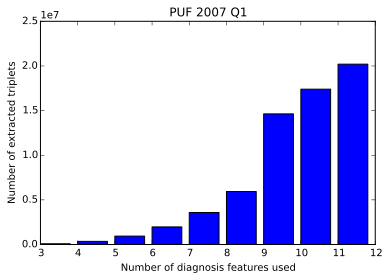

In [21]:
plt.bar(nvars, ntri)
plt.title('PUF 2007 Q1')
plt.xlabel('Number of diagnosis features used')
plt.ylabel('Number of extracted triplets')

##### The above is sligtly incorrect as there are repetitions in the list of codes for every claim. Most importantly:

#### Other stats to consider:

- Major hospitals
- Popular diagnoses
- Basic demographics
- Rural vs urban
- Got data for 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006 and 2007: cross reference with major events, seasonal occurences.

In [22]:
dif = diff.tolist()

In [23]:
dif.insert(0,0)

In [24]:
diff = np.array(dif)

In [25]:
diff

array([     0,  56214, 104082,  80893,  67767,  58724,  51644,  46195,
        41906, 103513,  23062,  16971,  14595,  19677,   9448,   9077,
         6599,   5124,   4325,   3817,   5977,   5197,    929,    843,
          923,   2454])

In [26]:
sum(diff)

739956

In [27]:
nclaims

740288

In [28]:
cdf = np.cumsum(diff)/float(sum(diff))

In [29]:
pdf = diff/float(sum(diff))

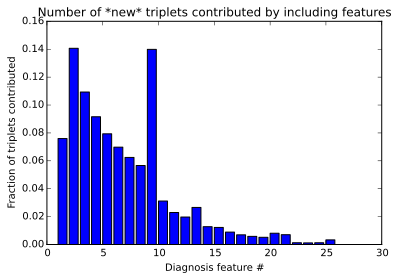

In [32]:
plt.bar(range(0, len(pdf)), pdf)
plt.title('Number of *new* triplets contributed by including features')
plt.xlabel('Diagnosis feature #')
plt.ylabel('Fraction of triplets contributed')

Including DIAG9 is (for some reason) especially beneficial

## What if claims were linked?

This section tries to predict how many triplets could be extracted from the data, if we had a fixed number of linked claims for each patient.

The PUF from DSHS does **not** contain linkable claims. This is just an estimate of what linkable claims **would** be able to give us.

In [33]:
pdf2 = np.convolve(pdf, pdf)

<Container object of 51 artists>

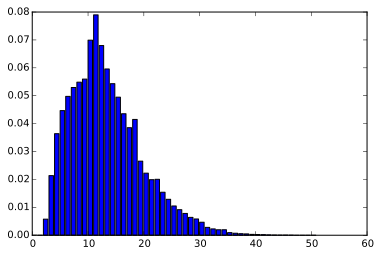

In [34]:
plt.bar(range(0, len(pdf2)), pdf2)

In [35]:
pdf4 = np.convolve(pdf2, pdf2)

<Container object of 101 artists>

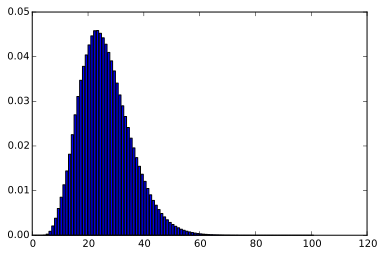

In [36]:
plt.bar(range(0, len(pdf4)), pdf4)

In [37]:
pdf8 = np.convolve(pdf4, pdf4)

In [38]:
pdf16 = np.convolve(pdf8, pdf8)

<Container object of 401 artists>

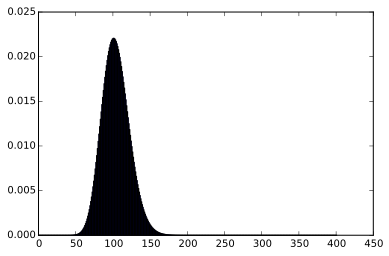

In [39]:
plt.bar(range(0, len(pdf16)), pdf16)

In [40]:
def calcNumberOfTrigramsPMF(nvars, pmf, claimsperpatient, nclaims=nclaims):
    pmfcut = pmf.copy()
    pmfcut[nvars+1:]=0
    pmfcut[nvars] = 1 - sum(pmfcut[:nvars])
    pconv = pmfcut.copy()
    for k in range(1,claimsperpatient):
        pconv = np.convolve(pconv.copy(),pmfcut)
    trigrams=[(nclaims/float(claimsperpatient))*pconv[i]*i*(i-1)*(i-2)/6 for i in range(3, len(pconv))]
    return sum(trigrams)

In [41]:
ntri = calcNumberOfTrigramsPMF(5, pdf, 1)
ntri

In [44]:
nvars = range(3,15)

### Set the average number of linked claims per patient 

In [55]:
numberOfClaimsPerPatient = 1

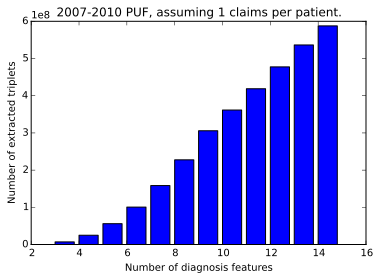

In [56]:
ntrip = [12*calcNumberOfTrigramsPMF(x, pdf, numberOfClaimsPerPatient) for x in nvars]
plt.bar(nvars, ntrip)
plt.title('2007-2010 PUF, assuming ' + str(numberOfClaimsPerPatient) + ' claims per patient.')
plt.xlabel('Number of diagnosis features')
plt.ylabel('Number of extracted triplets')

In [46]:
sum((nclaims*pdf-diff)/nclaims)

0.0004484741073743976

In [47]:
diff

array([     0,  56214, 104082,  80893,  67767,  58724,  51644,  46195,
        41906, 103513,  23062,  16971,  14595,  19677,   9448,   9077,
         6599,   5124,   4325,   3817,   5977,   5197,    929,    843,
          923,   2454])